## An Analysis of Gus Malzahn's 1st down play calls after a big play (20+ yards)

In [1]:
import pandas as pd
import numpy as np
import urllib
import matplotlib
import matplotlib.pyplot as plt

#### Establish the API Base URL and what we define as a "big play"

In [2]:
base = 'https://api.collegefootballdata.com'
big_play_minimum = 20

#### Identify the coach to analyze and fetch his data from the API

In [3]:
coach_first_name = 'Gus'
coach_last_name = 'Malzahn'
coach_df = pd.read_json('{}/coaches?firstName={}&lastName={}'.format(base, coach_first_name, coach_last_name))
coach_df

,first_name,last_name,seasons
0,Gus,Malzahn,"[{'school': 'Arkansas State', 'year': 2012, 'g..."


#### Format the JSON from the API response into a useful dataframe

In [4]:
coach_df2 = pd.read_json(coach_df['seasons'].to_json(orient='columns'))
coach_df2

,0
0,"{'school': 'Arkansas State', 'year': 2012, 'ga..."
1,"{'school': 'Auburn', 'year': 2013, 'games': 14..."
2,"{'school': 'Auburn', 'year': 2014, 'games': 13..."
3,"{'school': 'Auburn', 'year': 2015, 'games': 13..."
4,"{'school': 'Auburn', 'year': 2016, 'games': 13..."
5,"{'school': 'Auburn', 'year': 2017, 'games': 14..."
6,"{'school': 'Auburn', 'year': 2018, 'games': 13..."
7,"{'school': 'Auburn', 'year': 2019, 'games': 13..."
8,"{'school': 'Auburn', 'year': 2020, 'games': 0,..."


In [5]:
seasons_df = pd.read_json(coach_df2[0].to_json()).transpose()
seasons_df

,games,losses,postseason_rank,preseason_rank,school,sp_defense,sp_offense,sp_overall,srs,ties,wins,year
0,12,3,None,None,Arkansas State,30.2,32.5,1.2,3.6,0,9,2012
1,14,2,2,None,Auburn,23.4,46.8,25.2,22.1,0,12,2013
2,13,5,22,6,Auburn,22.1,45.2,24.2,21.1,0,8,2014
3,13,6,None,6,Auburn,23.1,36.1,14.6,9.1,0,7,2015
4,13,5,24,None,Auburn,18.4,32.1,15.3,16.8,0,8,2016
5,14,4,10,12,Auburn,11,35.4,24.7,23.6,0,10,2017
6,13,5,None,9,Auburn,14.1,36.9,23.6,15.0,0,8,2018
7,13,4,14,16,Auburn,14.9,33.9,21,22.1,0,9,2019
8,0,0,None,11,Auburn,20.7,33,12.6,13.3,0,0,2020


#### Create a dictionary of which team he coached in which years

In [6]:
year_dict = dict(zip(seasons_df.year, seasons_df.school))
year_dict

{2012: 'Arkansas State',
 2013: 'Auburn',
 2014: 'Auburn',
 2015: 'Auburn',
 2016: 'Auburn',
 2017: 'Auburn',
 2018: 'Auburn',
 2019: 'Auburn',
 2020: 'Auburn'}

#### Iterate over the games he coached and get the play by play data from when his team was on offense

In [7]:
after_all_play_df = pd.DataFrame()
for year in year_dict:
    team = year_dict[year]
    year = str(year)
    print(year + ': ' + team)
    weeks = pd.read_json('{}/games?year={}&team={}'.format(base, year, urllib.parse.quote(team)))
    for week in weeks['week'].tolist():
        plays = pd.read_json('{}/plays?year={}&week={}&offense={}'.format(base, year, week, urllib.parse.quote(team)))
        if not plays.empty:
            plays['after_big_play_flg'] = (plays['yards_gained'].shift() >= big_play_minimum) & (plays['scoring'].shift() == False) & (~plays['play_type'].isin(['Penalty','Timeout'])) & (plays['drive_number'] == plays['drive_number'].shift())
            if after_all_play_df.empty:
                after_all_play_df = plays.copy()
            else:
                after_all_play_df = pd.concat([after_all_play_df, plays])
after_all_play_df.head()

2012: Arkansas State
2013: Auburn
2014: Auburn
2015: Auburn
2016: Auburn
2017: Auburn
2018: Auburn
2019: Auburn
2020: Auburn


,away,clock,defense,defense_conference,defense_score,defense_timeouts,distance,down,drive_id,drive_number,...,period,play_number,play_text,play_type,ppa,scoring,yard_line,yards_gained,yards_to_goal,after_big_play_flg
0,Arkansas State,"{'minutes': 13, 'seconds': 8}",Oregon,Pac-12,8,NaN,10,1,32245248302,2,...,1,1,David Oku rush for no gain to the ArkSt 22.,Rush,-0.613590,False,78,0,78,False
1,Arkansas State,"{'minutes': 12, 'seconds': 45}",Oregon,Pac-12,8,NaN,10,2,32245248302,2,...,1,2,ARKANSAS ST penalty 5 yard False Start accepted.,Penalty,NaN,False,78,0,78,False
2,Arkansas State,"{'minutes': 12, 'seconds': 19}",Oregon,Pac-12,8,NaN,15,2,32245248302,2,...,1,3,Josh Jarboe rush for 1 yard to the ArkSt 18.,Rush,-0.103914,False,83,1,83,False
3,Arkansas State,"{'minutes': 11, 'seconds': 48}",Oregon,Pac-12,8,NaN,14,3,32245248302,2,...,1,4,Ryan Aplin pass complete to David Oku for 13 y...,Pass Completion,0.398290,False,82,13,82,False
4,Arkansas State,"{'minutes': 11, 'seconds': 2}",Oregon,Pac-12,8,NaN,1,4,32245248302,2,...,1,5,"Neely Sullivent punt for 42 yards, returned by...",Punt,NaN,False,69,6,69,False


#### Ensure each play is properly identified as a Rush or Pass, and remove plays that were not on 1st down

In [8]:
after_all_play_df['play_type_new'] = pd.np.where(after_all_play_df['play_type'].str.contains("Pass"), "Pass", pd.np.where(after_all_play_df['play_type'].str.contains("Rush"), "Rush", "Other"))
after_all_play_df = after_all_play_df[(after_all_play_df['play_type_new'] != "Other") & (after_all_play_df['down'] == 1)]

In [9]:
play_type_breakdown_big_play = after_all_play_df[after_all_play_df['after_big_play_flg'] == True]['play_type_new'].value_counts()
play_type_breakdown_non_big_play = after_all_play_df[after_all_play_df['after_big_play_flg'] == False]['play_type_new'].value_counts()

#### Graph results

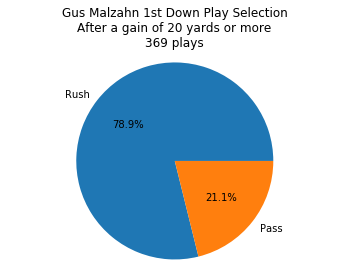

In [10]:
plt.pie(play_type_breakdown_big_play, labels=play_type_breakdown_big_play.index, autopct='%1.1f%%')
plt.title('{} {} 1st Down Play Selection\nAfter a gain of {} yards or more\n{} plays'.format(coach_first_name, coach_last_name, str(big_play_minimum), str(play_type_breakdown_big_play.sum())))
plt.axis('equal')
plt.show()

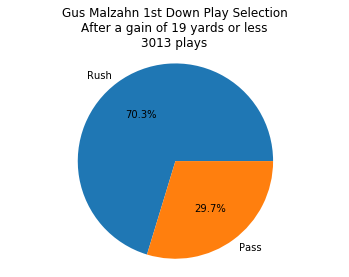

In [11]:
plt.pie(play_type_breakdown_non_big_play, labels=play_type_breakdown_non_big_play.index, autopct='%1.1f%%')
plt.title('{} {} 1st Down Play Selection\nAfter a gain of {} yards or less\n{} plays'.format(coach_first_name, coach_last_name, str(big_play_minimum - 1), str(play_type_breakdown_non_big_play.sum())))
plt.axis('equal')
plt.show()

#### Get the average Predicted Points Add (ppa) for each group of plays

In [12]:
summary = after_all_play_df.rename(columns={'after_big_play_flg':'After Big Play?','play_type_new':'Play Type'})
pd.pivot_table(summary, values='ppa', index='Play Type', columns='After Big Play?').round(2)

After Big Play?,False,True
Play Type,,
Pass,0.22,0.11
Rush,0.08,0.06
